In [3]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT

from root_pandas import read_root, to_root

from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

from tqdm import tqdm
from itertools import islice

from collections import OrderedDict

from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.unumpy import nominal_values as nom
from uncertainties.unumpy import std_devs as std
import uncertainties.unumpy as unp

from scripts.metrics import tagging_power_score
from scripts.calibration import PolynomialLogisticRegression
from scripts.data_preparation import get_event_number

In [47]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

# read and prepare dataset

In [5]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
run_1_filenames = ['Bu2JpsiK_mu-k-e-TrainingTuple_2011_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2011_MU_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2012_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2012_MU_sweighted_kheinick.root',
                   ]
run_2_filenames = ['Bu2JpsiK_mu-k-e-TrainingTuple_2015_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2015_MU_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2016_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2016_MU_sweighted_kheinick.root',
                   ]
chunksize = 5000
maxslices = None

In [6]:
datasets = OrderedDict([
    ('RUNI', {
        'filenames': [data_dir + f for f in run_1_filenames],
    }),
    ('RUNII', {
        'filenames': [data_dir + f for f in run_2_filenames],
    }),
])

In [7]:
# just define some keyword arguments for read_root in a separate dict
data_kwargs = dict(
    key='DecayTree',  # the tree name
    columns=['B_OS_Muon*',  # all branches that should be read
             'B_ID',
             'B_PT',
             'runNumber',
             'eventNumber',
             'SigYield_sw',
            ],
    chunksize=chunksize,  # this will create a generator, yielding subsets with 'chunksize' of the data
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',  # a ROOT where selection, does not work with array-variables
    flatten=True  # will flatten the data in the dimension of the first given column
)

In [8]:
# Read datasets and fill several event information
for key, d in datasets.items():
    filenames = d['filenames']
    entries = 0
    for f in filenames:
        rootfile = ROOT.TFile(f)
        tree = rootfile.Get('DecayTree')
        entries += tree.GetEntries()
    datasets[key]['entries'] = entries
    if maxslices is not None and maxslices < entries/chunksize:
        total = maxslices
    else:
        total = entries/chunksize
    df = pd.concat([df for df
                    in tqdm(islice(read_root(filenames, **data_kwargs), maxslices),
                            total=total)])
    df.rename(columns=dict(zip(df.columns, [c.replace('B_OS_Muon', 'tp') for c in df.columns])), inplace=True)
    df['target'] = np.sign(df.B_ID) == np.sign(df.tp_ID)
    df['event_id'] = df.runNumber.apply(str) + '_' + df.eventNumber.apply(str)
    df['tp_ABS_RecVertexIP'] = np.abs(df.tp_RecVertexIP)
    datasets[key]['data'] = df
    datasets[key]['event_number'] = ufloat(get_event_number(df), np.sqrt(get_event_number(df)))

245it [04:45,  1.03s/it]                              
61it [00:58,  1.22it/s]                             


# apply muon-specific selections

In [9]:
# this is the list of BDT variables formerly used
MVA_features = [
    'tp_partP',
    'tp_partPt',
    'tp_IPPU',
    'tp_ghostProb',
    'tp_PIDNNm',
    'tp_RecVertexIP',
    'tp_mult',
    'tp_ptB',
    'tp_IPs',
    'tp_partlcs',
    'tp_PROBNNpi',
    'tp_PROBNNk',
    'tp_PROBNNp',
    'tp_PROBNNe',
]

In [10]:
class NSplit(object):
    def __init__(self, df, splits=3, shuffle=True):
        self.df = df
        self.df.reset_index(inplace=True, drop=True)
        self.unique_events = self.df.event_id.unique()
        self.raw_indices = np.arange(len(df))
        if shuffle:
            np.random.shuffle(self.unique_events)
        self.raw_index_sets = np.array_split(self.unique_events, splits)
    
    def __iter__(self):
        for index_set in self.raw_index_sets:
            yield self.raw_indices[self.df.event_id.isin(index_set).values]

In [24]:
# train a bdt to spredict the correct-ness of a tag
for key, d in datasets.items():
    df = d['data']
    splits = NSplit(df)
    train_data, test_data, calib_data = [df.iloc[indices] for indices in splits]
    for subset_name in ['train_data', 'test_data', 'calib_data']:
        datasets[key][subset_name] =  locals()[subset_name].copy(deep=True)
    model = XGBClassifier(max_depth=2, n_estimators=200, nthread=12)
    model.fit(train_data[MVA_features], train_data.target)
    datasets[key]['model'] = model
    for subset_name in ['train_data', 'test_data', 'calib_data', 'data']:
        datasets[key][subset_name]['proba'] = model.predict_proba(datasets[key][subset_name][MVA_features])[:,1]

In [25]:
# select best candidates
for key, d in datasets.items():
    for subset_name in ['train_data', 'test_data', 'calib_data', 'data']:
        df = d[subset_name]
        df.reset_index(drop=True, inplace=True)
        datasets[key]['max_' + subset_name] = df.iloc[df.groupby('event_id')['proba'].idxmax()]

In [26]:
# calibrate
for key, d in datasets.items():
    calib_df = d['max_calib_data']
    calibrator = PolynomialLogisticRegression(4, solver='lbfgs')
    calibrator.fit(calib_df.proba, calib_df.target, sample_weight=calib_df.SigYield_sw)
    datasets[key]['calibrator'] = calibrator
    for subset_name in ['train_data', 'test_data', 'calib_data', 'data']:
        datasets[key]['max_' + subset_name]['calib_proba'] = \
            calibrator.predict_proba(datasets[key]['max_' + subset_name].proba)[:, 1]

/opt/rh/miniconda/envs/mkl_test/lib/python3.4/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
def proba_bins(x, y_true, errs=True, bins=10, range=None, sample_weight=None):
    """ Bin data by x and calculate the amount of y_true in each bin,
        errors will be (bin_width/2, sqrt(bin_count))
    """
    if sample_weight is None:
        sample_weight = np.ones(x.shape)

    hist, bin_edges = np.histogram(x, bins=bins, range=range)
    xs = np.array([(x_low + x_high)/2 for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
    true_sums = np.array([np.sum(sample_weight[(x > x_low) & (x <= x_high)])
                          for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
    ys = (np.array([np.sum(sample_weight[(x > x_low) & (x <= x_high) & (np.array(y_true) == True)])
                    for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
          / true_sums)
    if errs:
        y_errs = (np.array([np.sqrt(np.sum(sample_weight[(x > x_low) & (x <= x_high) & (np.array(y_true) == False)]))
                            for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
                  / true_sums)
        x_errs = [(x_high - x_low) / 2 for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])]
        return xs, ys, y_errs, x_errs
    else:
        return xs, ys

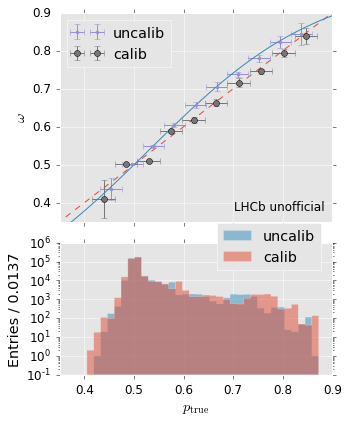

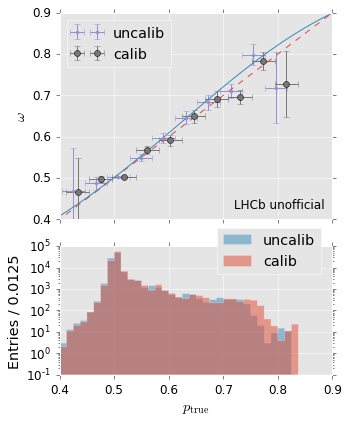

In [43]:
for (key, d), ylim, xlim in zip(datasets.items(),
                                [(0.35, 0.9), (0.4, 0.9)],
                                [(0.35, 0.9), (0.4, 0.9)]):
    xs = np.linspace(*xlim)
    fig = plt.figure(figsize=(5, 6))
    ax_top = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
    ax_bottom = plt.subplot2grid((5, 1), (3, 0), sharex=ax_top, rowspan=2)
    plt.axes(ax_top)
    plt.plot([0, 1], '--')
    test_data = d['max_test_data']
    plt.plot(xs, d['calibrator'].predict_proba(xs)[:, 1])
    plt.errorbar(*proba_bins(test_data.proba.values, test_data.target.values,
                             sample_weight=test_data.SigYield_sw), label='uncalib', fmt='.')
    plt.errorbar(*proba_bins(test_data.calib_proba.values, test_data.target.values,
                             sample_weight=test_data.SigYield_sw), label='calib', fmt='o')
    plt.text(0.97, 0.04, 'LHCb unofficial', ha='right', va='bottom', transform=plt.gca().transAxes)
    plt.setp(ax_top.get_xticklabels(), visible=False)
    plt.xlim(xlim)
    plt.ylim(ylim)
#     plt.locator_params(axis='x', nbins=5)
    plt.legend(loc='best')
    plt.ylabel(r'$\omega$')
    
    plt.axes(ax_bottom)
    _, bins, _ = plt.hist([test_data.calib_proba, test_data.proba],
                          label=['calib', 'uncalib'], alpha=0.5, range=xlim, bins=40, histtype='stepfilled',
                          log=True)
    binwidth = (bins[1] - bins[0])
    plt.legend(loc='upper left', bbox_to_anchor=(0.55, 1.2))
    plt.ylabel('Entries / {:.4f}'.format(binwidth))
    plt.xlabel(r'$p_\mathrm{true}$')
    
    plt.tight_layout()
    plt.savefig('./build/p-calibration-{}.pdf'.format(key), bbox_inches='tight')
    plt.show()

/opt/rh/miniconda/envs/mkl_test/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RUNI: max tp: 1.1209+/-0.0026%
RUNII: max tp: 0.862+/-0.004%


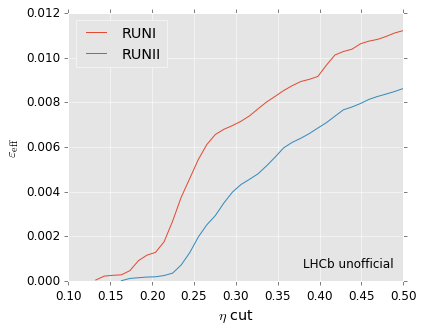

In [48]:
# plot stuff
plt.figure(figsize=(6, 4.8))
for key, d in datasets.items():
    tps = []
    df = d['max_test_data']
    df['etas'] = np.where(df.calib_proba.values > 0.5, 1 - df.calib_proba.values, df.calib_proba.values)
    len_before = get_event_number(df)
    len_before = ufloat(len_before, np.sqrt(len_before))
    cut_values = np.linspace(0, 0.5)
    for cut in cut_values:
        selected_data = df[df.etas < cut]
        len_after = get_event_number(selected_data)
        len_after = ufloat(len_after, np.sqrt(len_after))
        efficiency = len_after / len_before
        try:
            tp = tagging_power_score(selected_data.etas,
                                     efficiency=efficiency,
                                     )
            tps.append(tp)
        except:
            tps.append(ufloat(0, 0))
    tps = np.array(tps)
    print('{}: max tp: {}%'.format(key, 100 * tps.max()))
#     plt.fill_between(cut_values, nom(tps) - std(tps), nom(tps) + std(tps), alpha=0.3)
    plt.plot(cut_values, nom(tps), label=key)

plt.text(0.97, 0.04, 'LHCb unofficial', ha='right', va='bottom', transform=plt.gca().transAxes)
plt.xlabel(r'$\eta$ cut')
plt.ylabel(r'$\varepsilon_\mathrm{eff}$')
plt.legend(loc='best')
plt.savefig('./build/bdt-eta-cut.pdf')
plt.show()

In [31]:
to_root(datasets['RUNI']['max_data'], './data/bdt-selection-run1.root')

/home/kheinicke/.local/lib/python3.4/site-packages/root_numpy/_tree.py:570: UserWarning: converter for dtype('O') is not implemented (skipping)
  _librootnumpy.array2root(arr, filename, treename, mode)


In [32]:
to_root(datasets['RUNII']['max_data'], './data/bdt-selection-run2.root')

/home/kheinicke/.local/lib/python3.4/site-packages/root_numpy/_tree.py:570: UserWarning: converter for dtype('O') is not implemented (skipping)
  _librootnumpy.array2root(arr, filename, treename, mode)


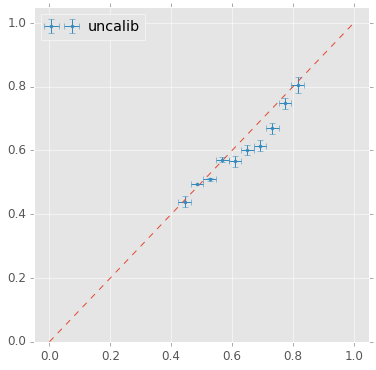

RUNI RUNII 0.0123987734635


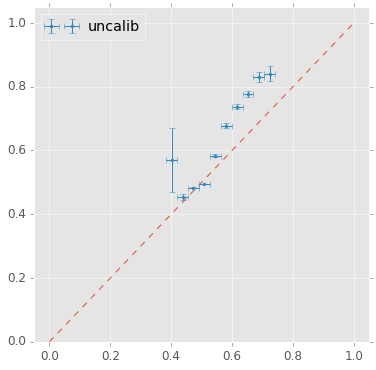

RUNII RUNI 0.00252867876795


In [41]:
for key, d in datasets.items():
    for crosskey, crossd in datasets.items():
        if key != crosskey:
            model = d['model']
            calib = crossd['calib_data']
            test = crossd['test_data']
            calib['cross_probas'] = model.predict_proba(calib[MVA_features])[:, 1]
            test['cross_probas'] = model.predict_proba(test[MVA_features])[:, 1]
            test.reset_index(drop=True, inplace=True)
            max_test = test.iloc[test.groupby('event_id')['cross_probas'].idxmax()]
            plt.figure(figsize=(6, 6))
            plt.plot([0, 1], '--')
            plt.errorbar(*proba_bins(test.cross_probas, test.target,
                         sample_weight=test.SigYield_sw), label='uncalib', fmt='.')
            plt.xlim(-0.05, 1.05)
            plt.ylim(0, 1.05)
            plt.legend(loc='best')
            plt.show()
            print(key, crosskey, tagging_power_score(max_test.cross_probas, 1, sample_weight=max_test.SigYield_sw))